In [22]:
import torch
import numpy as np
import pickle
from utils import groundtruth
from utils import pde_VPINN as pde
from utils import model,tools,validation
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm

In [23]:
dtype = torch.float64


resolution = 128
val_x1=np.arange(0,1,1/resolution).reshape(-1,1)
val_x2=np.arange(0,1,1/resolution).reshape(-1,1)
t_vx1 = torch.from_numpy(val_x1).type(dtype)
t_vx2 = torch.from_numpy(val_x2).type(dtype)



#Generate grids to output graph
val_ms_x1, val_ms_x2 = np.meshgrid(val_x1, val_x2)

plot_val_x1 = np.ravel(val_ms_x1).reshape(-1,1)
plot_val_x2 = np.ravel(val_ms_x2).reshape(-1,1)


t_val_vx1,t_val_vx2 = tools.from_numpy_to_tensor([plot_val_x1,plot_val_x2],[False,False],dtype=dtype)

In [24]:
np.ravel(val_ms_x1).shape

(16384,)

In [9]:
y_net = torch.load("results/VPINN_t1/u_net.pt")
y_b = torch.load("results/VPINN_t1/ub.pt")

def y_vpinn_pre(qp):
    return y_net(qp,y_b)

def y_vpinn(x1,x2):
    return y_vpinn_pre(torch.cat([x1,x2],1).unsqueeze(1))

y_drm = torch.load('results/DRM_paper2/y.pt')
y_pinn = torch.load('results/PINN_t2/y.pt')
y_wan = torch.load('results/WAN/t4/solNet.pt')

In [10]:
validation.validate(y_wan)

(0.06423085752226784,
 array([[ 0.00395987],
        [ 0.0053809 ],
        [ 0.00680937],
        ...,
        [-0.00153353],
        [-0.00199282],
        [-0.00239176]]),
 array([[0.00000000e+00],
        [6.10351562e-05],
        [2.44140625e-04],
        ...,
        [5.49316406e-04],
        [2.44140625e-04],
        [6.10351562e-05]]))

In [29]:
from torch import mode


def validate_model(model_path_list):
    validate_list = []
    for model_path in model_path_list:
        y_model = torch.load(model_path)
        val,a,b, = validation.validate(y_model)
        validate_list.append(val)
    return validate_list

model_path_list = ["results/WAN/t4"+"/solNet.pt","results/WAN/Test1_AdaGrad_all/solNet4900.pt","results/WAN/Test1_AdaGrad31_all/solNet4900.pt"]
model_path_list.append("results/WAN/t6/solNet4900.pt")
val_list = validate_model(model_path_list)

print(val_list)

print(np.std(val_list))

[0.06423085752226784, 0.07368876737080145, 0.0612591981176389, 0.07635901574839632]
0.006299821182866329


In [35]:
from torch import mode


def validate_model(model_path_list):
    validate_list = []
    for model_path in model_path_list:
        y_model = torch.load(model_path)
        val,a,b, = validation.validate(y_model)
        validate_list.append(val)
    return validate_list

model_path_list = ["results/PINN_t"+str(i)+"/y.pt" for i in [1,2,4,6,7,8]]
val_list = validate_model(model_path_list)

print(val_list)

print(np.std(val_list))

[0.6495252714039103, 0.537968927496327, 0.5565834431979203, 0.5340672536064193, 0.5389851036221464, 0.5341353838529735]
0.04139688237296552


In [11]:
ms_ysol = y(torch.cat([t_val_vx1,t_val_vx2],1).unsqueeze(1)).detach().numpy().reshape(resolution,resolution)


NameError: name 'y' is not defined

In [ ]:


fig_1 = plt.figure(1, figsize=(6, 5))
plt.pcolor(val_ms_x1,val_ms_x2,ms_ysol, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('figure/NNsolution',bbox_inches='tight')


NameError: name 'ms_ysol' is not defined

<Figure size 600x500 with 0 Axes>

In [12]:
sns.set_theme(style='white')
def plot_2D_data(fig,ax,data,title="",xlabel="",ylabel="",barlabel="",format=None,titlefs=25,labelfs=45,normminmax=None,is_colorbar = True):
    mpl.rcParams['font.size'] = titlefs
    plot_data = data.copy()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_axis_off()
    mpl.rcParams['font.size'] = labelfs
    if is_colorbar:
        if normminmax is not None:
            #im = ax.imshow(plot_data,cmap=cm.coolwarm,norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
            im = ax.pcolor(val_ms_x1,val_ms_x2,plot_data, cmap='jet',norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=1.,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))        
            #cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=0.82,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
        else:
            #im = ax.imshow(plot_data,cmap=cm.coolwarm)
            im = ax.pcolor(val_ms_x1,val_ms_x2,plot_data, cmap='jet')
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=1.,pad=0.03,format=format,spacing="proportional")
        cbar.ax.tick_params(labelsize=labelfs)

def plot_2D_func(net,*args,**kwargs):
    pt_u = net(t_val_vx1,t_val_vx2).detach().numpy().reshape([resolution,resolution])
    plot_2D_data(data=pt_u,*args,**kwargs)

def plot_err(net,data,*args,**kwargs):
    pt_u = net(t_val_vx1,t_val_vx2).detach().numpy().reshape([resolution,resolution])
    err = np.abs(pt_u-data)
    plot_2D_data(data = err,*args,**kwargs)

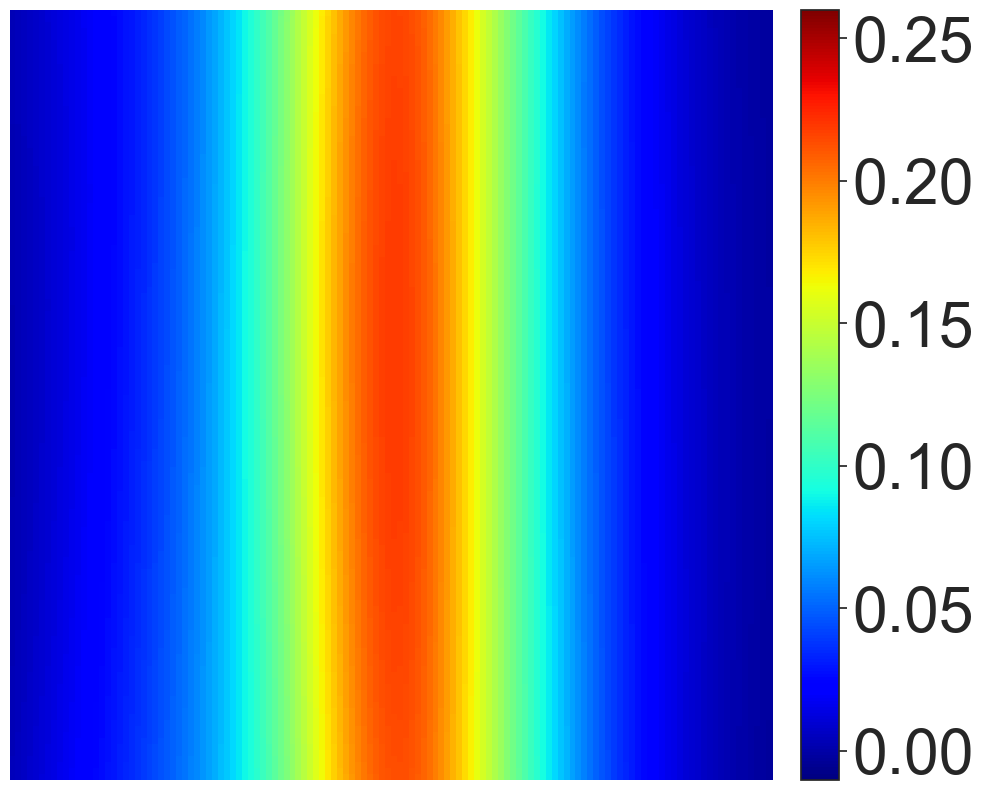

In [13]:
vmin = -0.01
vmax = 0.26
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_func(y_wan,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_wan",dpi=300,bbox_inches="tight")

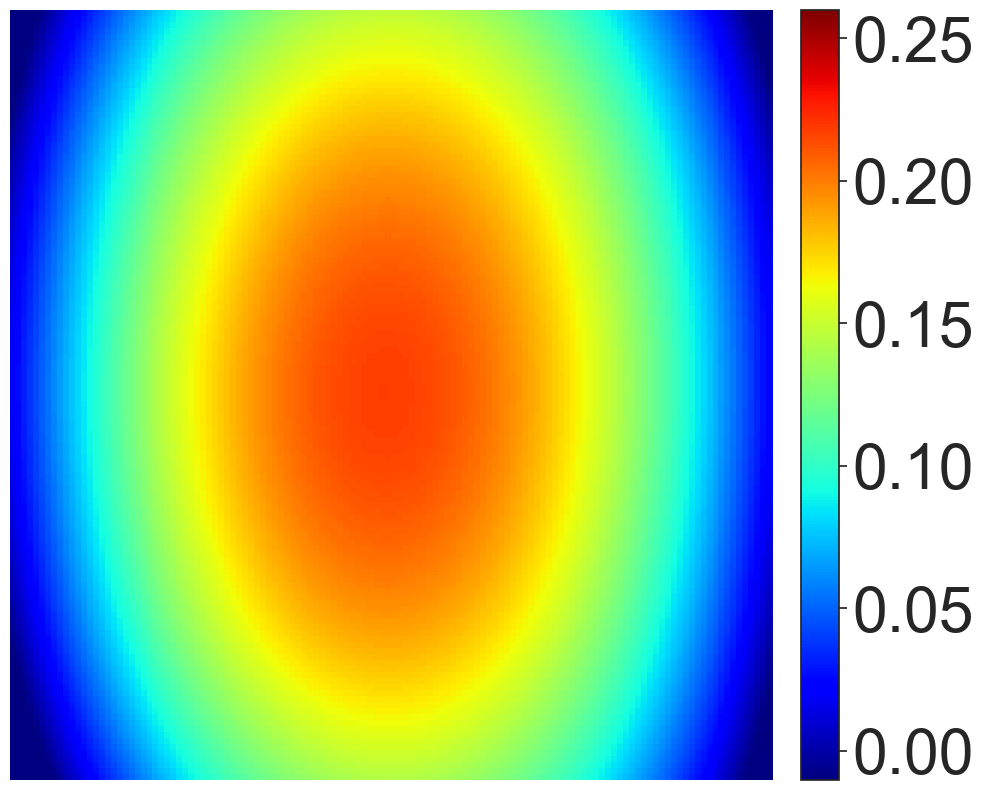

In [14]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_func(y_pinn,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_pinn",dpi=300,bbox_inches="tight")

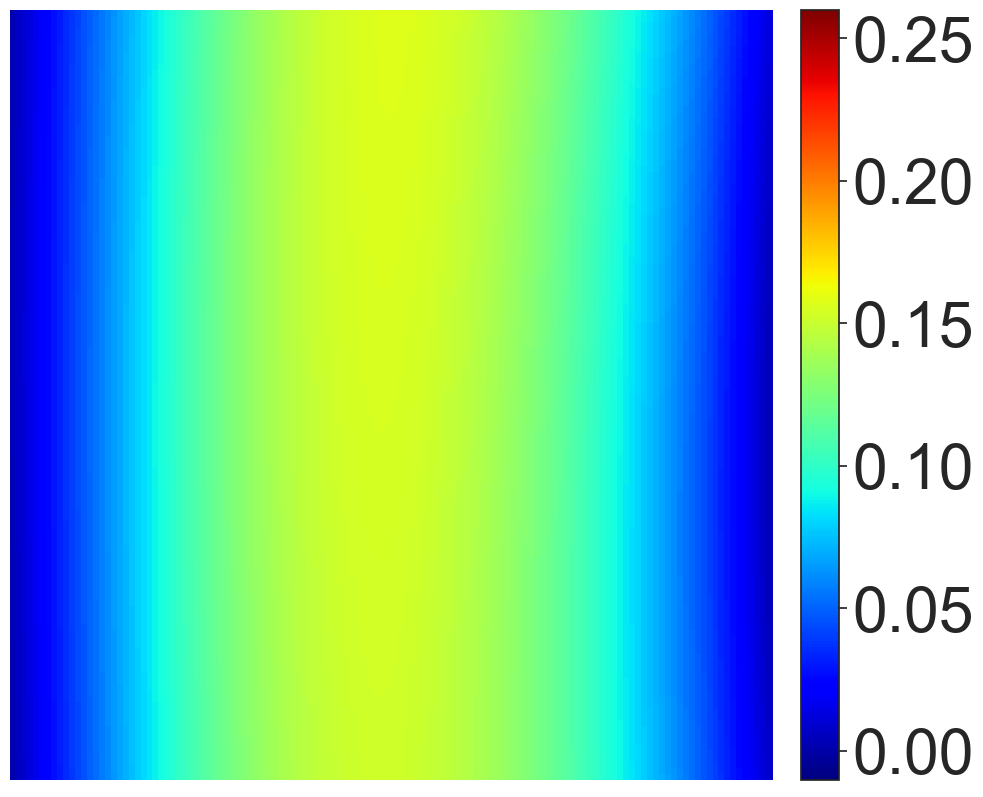

In [15]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_func(y_drm,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_drm",dpi=300,bbox_inches="tight")

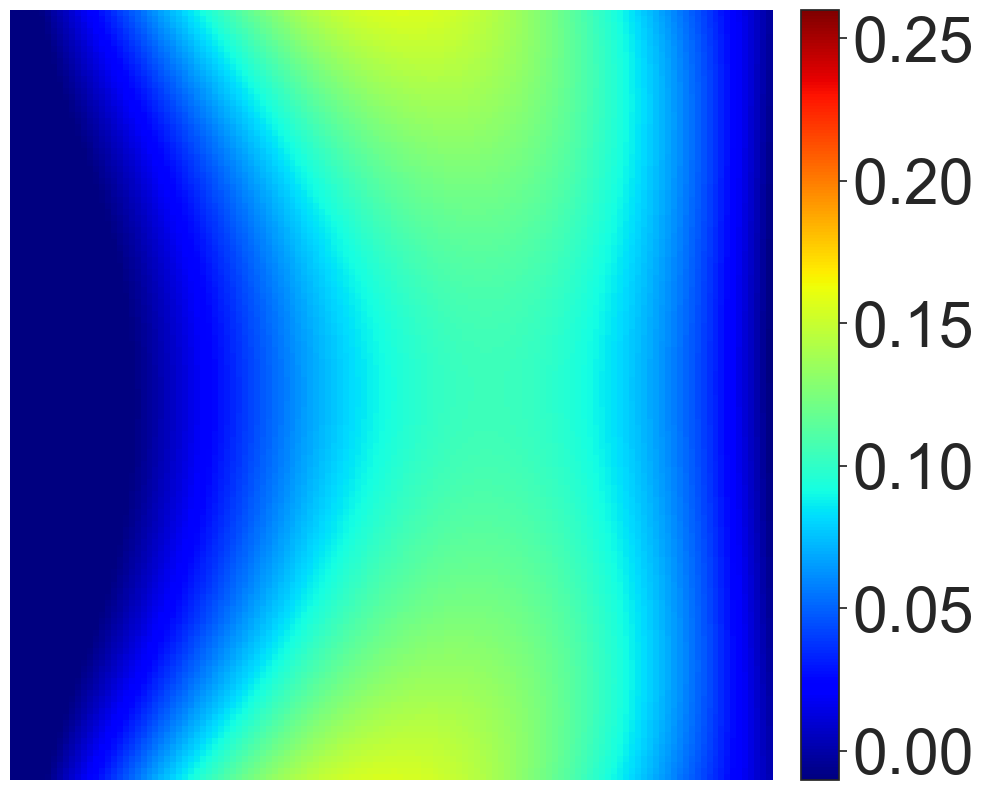

In [16]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_func(y_vpinn,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_vpinn",dpi=300,bbox_inches="tight")

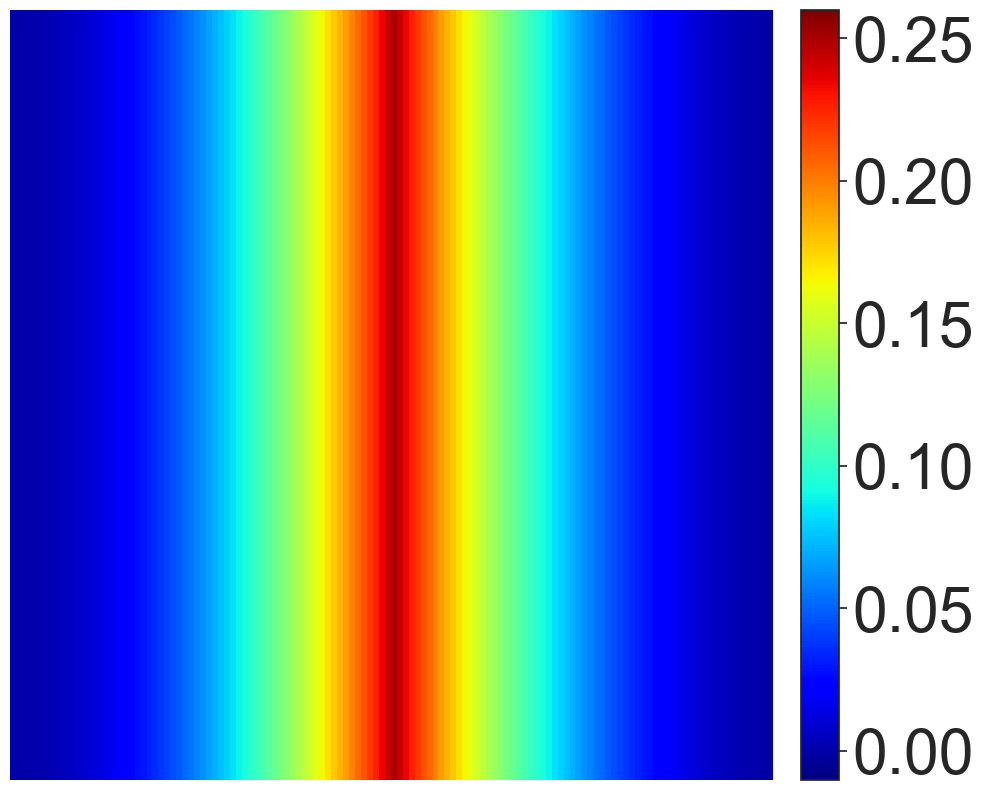

In [17]:
gtgen = groundtruth.gt_gen()

ygt = gtgen.generate_data(gtgen.y,np.concatenate([val_ms_x1.reshape(-1,1),val_ms_x2.reshape(-1,1)],1)).reshape(resolution,resolution)

fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_data(data=ygt,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_gt",dpi=300,bbox_inches="tight")

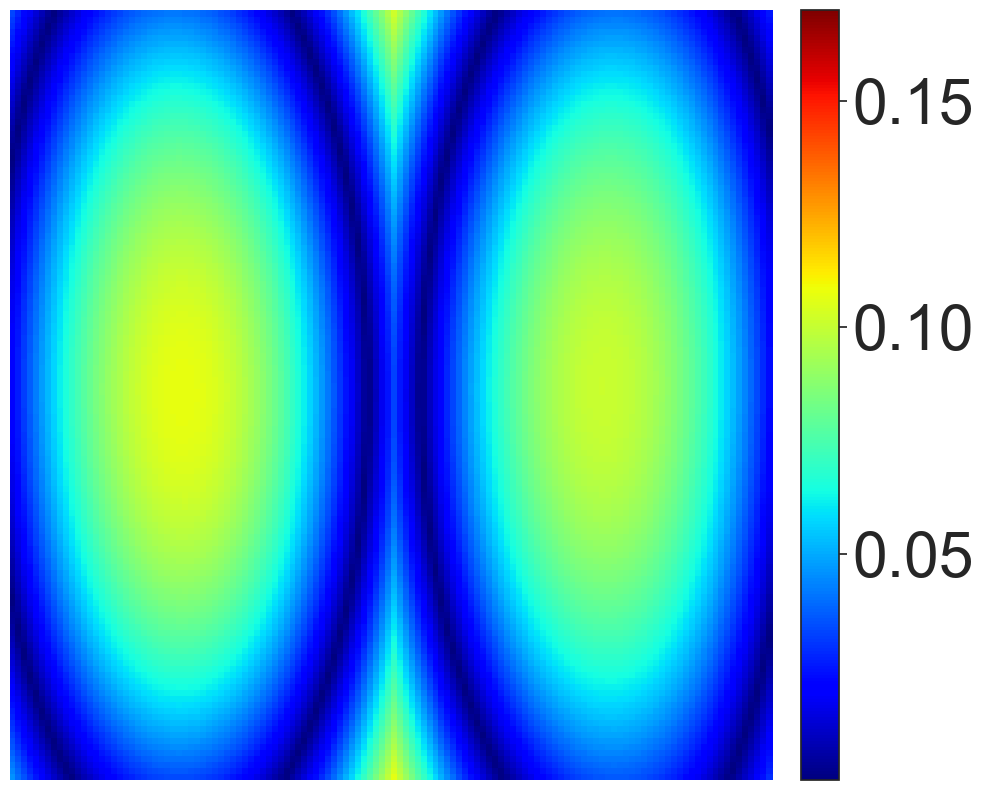

In [19]:
vmin = 0.0001
vmax = 0.17
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_err(net=y_pinn,data=ygt,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_pinn_err",dpi=300,bbox_inches="tight")

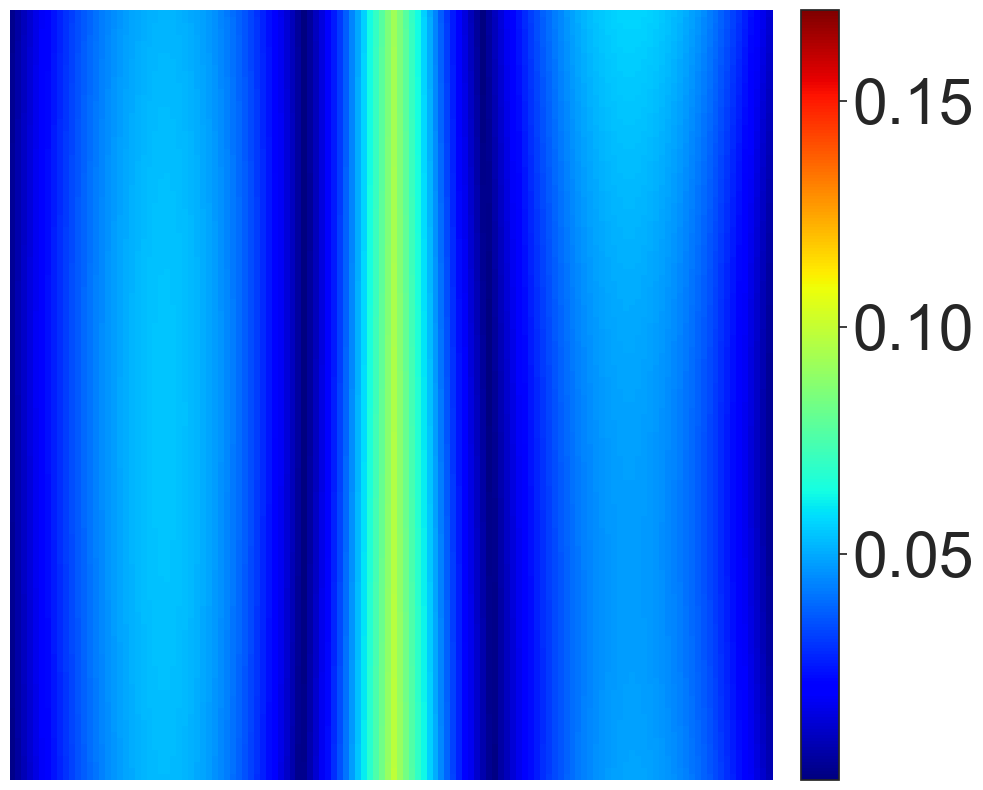

In [20]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_err(net=y_drm,data=ygt,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_drm_err",dpi=300,bbox_inches="tight")

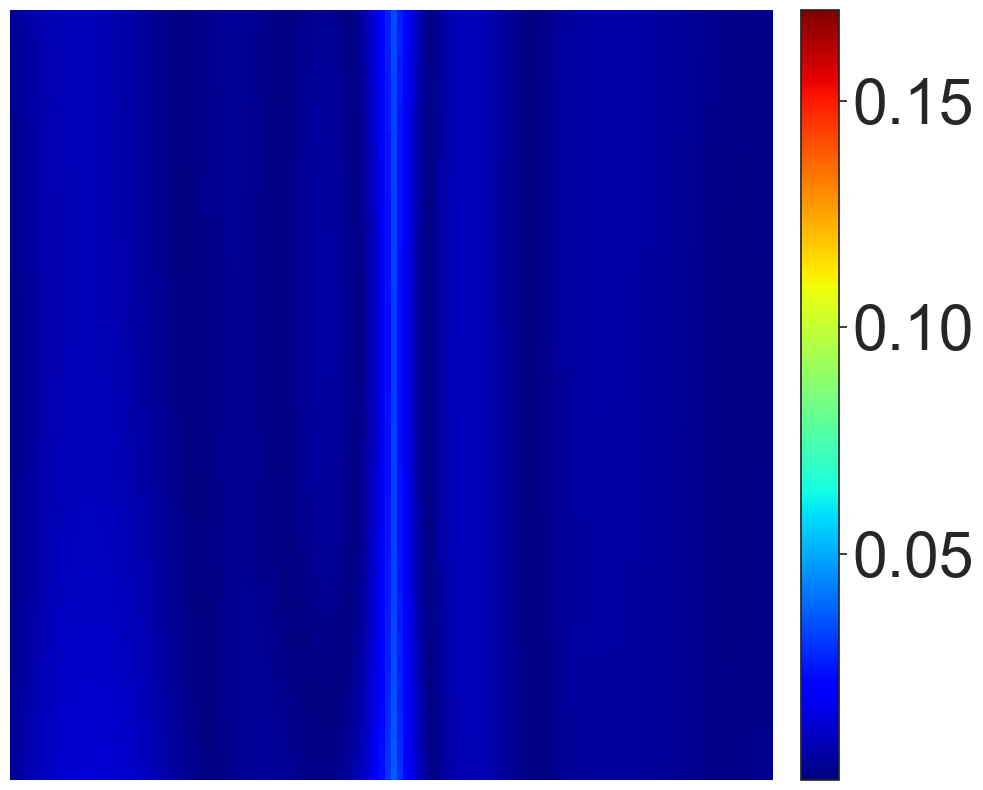

In [21]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_err(net=y_wan,data=ygt,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_wan_err",dpi=300,bbox_inches="tight")

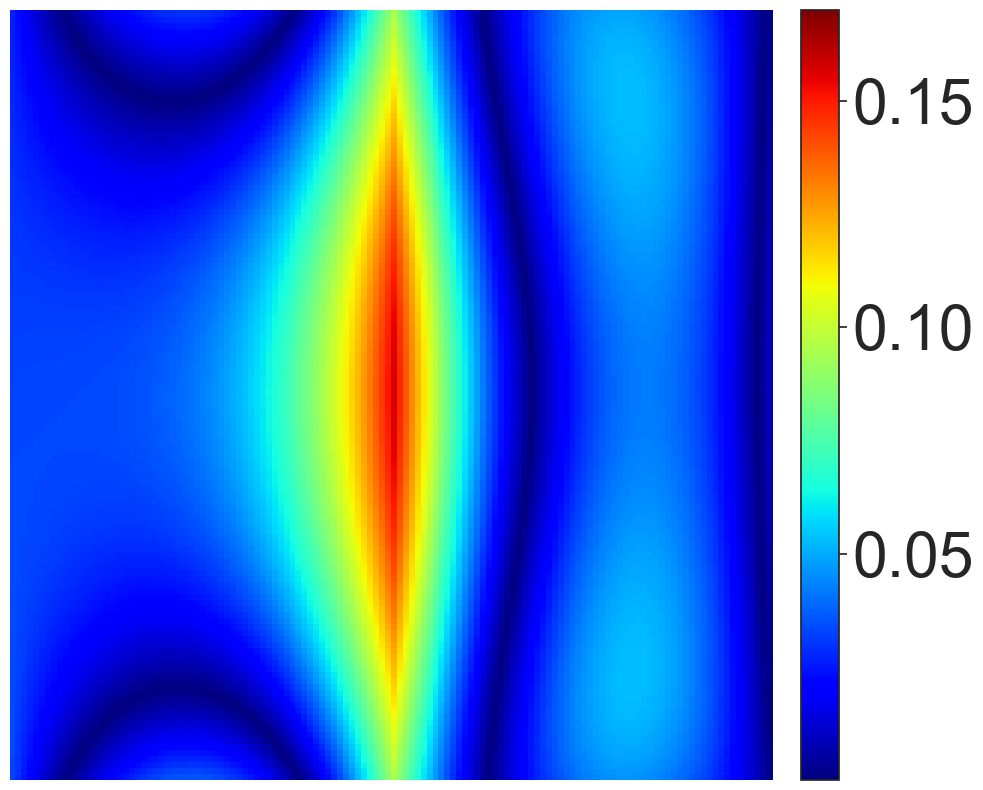

In [ ]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_err(net=y_vpinn,data=ygt,fig=fig,ax=ax,normminmax=[vmin,vmax])
plt.savefig("figures/y_vpinn_err",dpi=300,bbox_inches="tight")

In [ ]:
import pickle as pkl 
with open("/Users/dual/Documents/projects/ReviewArticle/Poisson_EX3/results/WAN/t5/vlist",'rb') as pfile:
    vl5 = pkl.load(pfile)

with open("/Users/dual/Documents/projects/ReviewArticle/Poisson_EX3/results/WAN/t4/vlist",'rb') as pfile:
    vl4 = pkl.load(pfile)

with open("/Users/dual/Documents/projects/ReviewArticle/Poisson_EX3/results/WAN/t3/vlist",'rb') as pfile:
    vl3 = pkl.load(pfile)

In [ ]:
len(vl3)

500

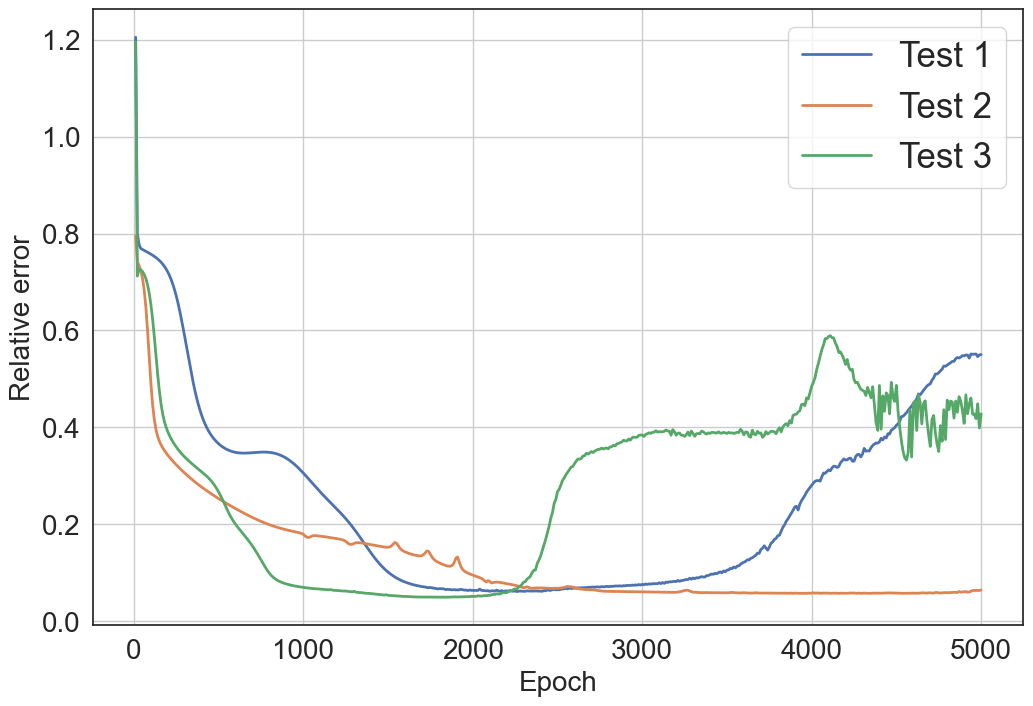

In [ ]:
fig,ax = plt.subplots(figsize=[12,8])
plt.plot(np.arange(1,len(vl3)+1)*10,vl3,label="Test 1",linewidth=2.0)
plt.plot(np.arange(1,len(vl3)+1)*10,vl4,label="Test 2",linewidth=2.0)
plt.plot(np.arange(1,len(vl3)+1)*10,vl5,label="Test 3",linewidth=2.0)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid()
plt.ylabel("Relative error",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(fontsize=25)
plt.savefig("figures/wan_convergence",dpi=300,bbox_inches="tight")